In [529]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [530]:
df = pd.read_csv('data.csv')

In [531]:
df.shape

(9529, 19)

In [532]:
df.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


##  Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [533]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median


In [534]:
df.drop(['Id','minutes_played_median','position','name'], axis=1, inplace=True)


In [535]:
# Completeness
df.isnull().sum()

team                0
age                 0
appearance          0
goals               0
assists             0
goals conceded      0
clean sheets        0
minutes played      0
days_injured        0
games_injured       0
award               0
current_value       0
highest_value       0
position_encoded    0
position_grouped    0
dtype: int64

In [536]:
# Accurecy types
df.dtypes

team                 object
age                 float64
appearance            int64
goals               float64
assists             float64
goals conceded      float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
position_grouped     object
dtype: object

In [537]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [538]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [539]:
for i in numeric_features:
    print (df[i].value_counts())

position_grouped
Defender Centre-Back          1683
Goalkeeper                    1172
midfield-CentralMidfield      1046
Attack Centre-Forward         1011
midfield-DefensiveMidfield     828
Defender Right-Back            808
Defender Left-Back             753
midfield-AttackingMidfield     645
Attack-RightWinger             613
Attack-LeftWinger              591
Other                          379
Name: count, dtype: int64
position_encoded
2    3277
3    2766
4    2314
1    1172
Name: count, dtype: int64
current_value
1000000     429
300000      425
500000      404
50000       391
1500000     383
           ... 
4400000       1
1750000       1
925000        1
21000000      1
3100000       1
Name: count, Length: 103, dtype: int64
award
0     4461
1     2049
2     1084
3      637
4      397
5      264
6      179
7      164
8       91
9       84
10      54
11      43
12      22
Name: count, dtype: int64
games_injured
0     3952
2      254
3      236
4      221
1      219
      ... 
84   

#### 2. Feature engineering

1. Feature scaling

2. Aggregation

3. One hot coding

In [540]:
df.head(2)

,team,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped
0,Manchester United,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper
1,Manchester United,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper


In [541]:
categorical_features

['team']

In [542]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [543]:
df.shape

(9529, 388)

In [544]:
# Calculate the 35th and 75th percentiles of the price
p25 = df['current_value'].quantile(0.25)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p25:
        return 'Average Player'
    elif current_value < p75:
        return 'Good Player'
    else:
        return 'Professional Player'

# Apply the function to create a new column
df['player_leval_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_leval_category'].value_counts())

player_leval_category
Good Player            4710
Professional Player    2443
Average Player         2376
Name: count, dtype: int64


In [545]:
p25,p75

(300000.0, 2500000.0)

In [546]:
encoder = LabelEncoder()
df['player_leval_category_encoded'] = encoder.fit_transform(df['player_leval_category']) 


#### 3. Feature selection

In [547]:
correlation = df.corr(numeric_only=True)
print(correlation['player_leval_category_encoded'].sort_values(ascending=False))

player_leval_category_encoded    1.000000
highest_value                    0.535701
appearance                       0.522449
minutes played                   0.492813
assists                          0.282450
                                   ...   
team_Al-Adalah FC               -0.069449
team_Al-Batin FC                -0.072292
team_Royal AM FC                -0.075967
team_Marumo Gallants FC         -0.076551
goals conceded                  -0.133234
Name: player_leval_category_encoded, Length: 387, dtype: float64


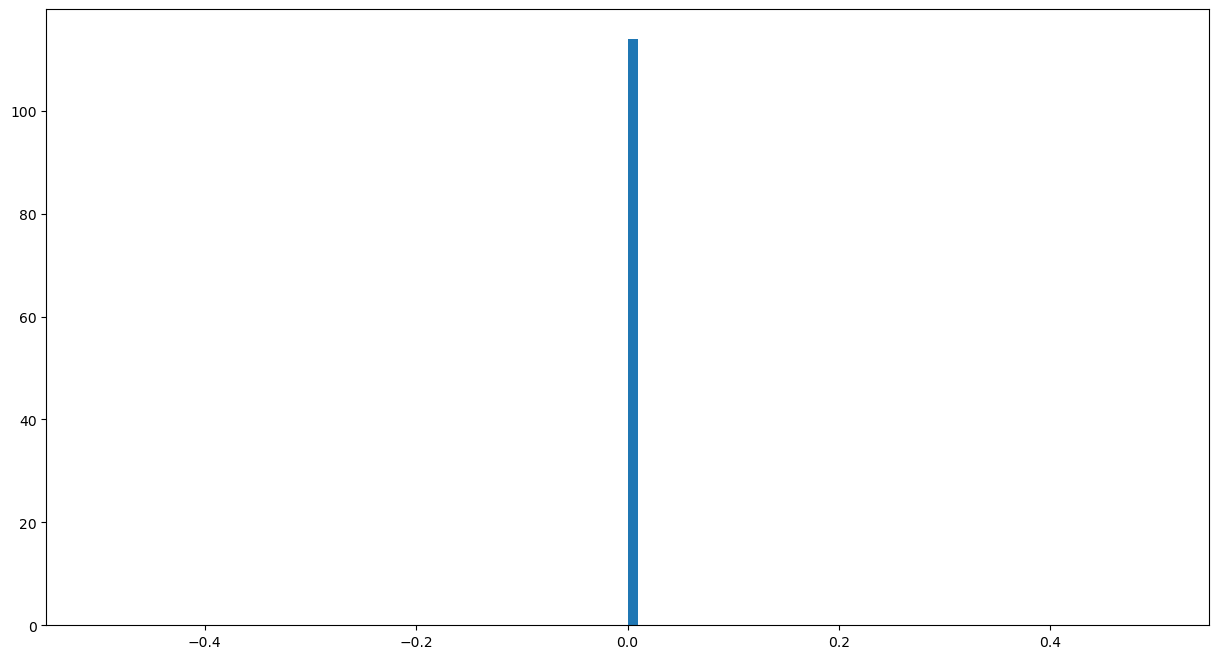

In [548]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['highest_value'])
plt.hist(df[df['highest_value']<=0.25]['highest_value'],bins=100);

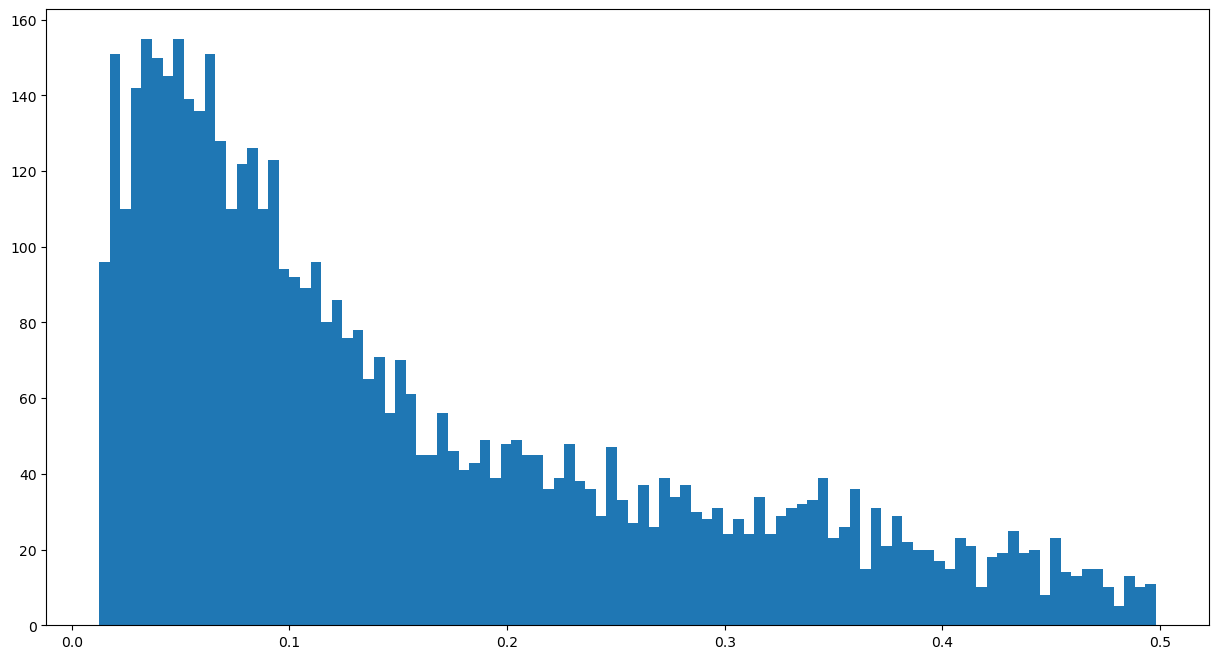

In [549]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['goals'])
plt.hist(df[(df['goals']<=0.5) & (df['goals']>0.0125)]['goals'], bins=100);

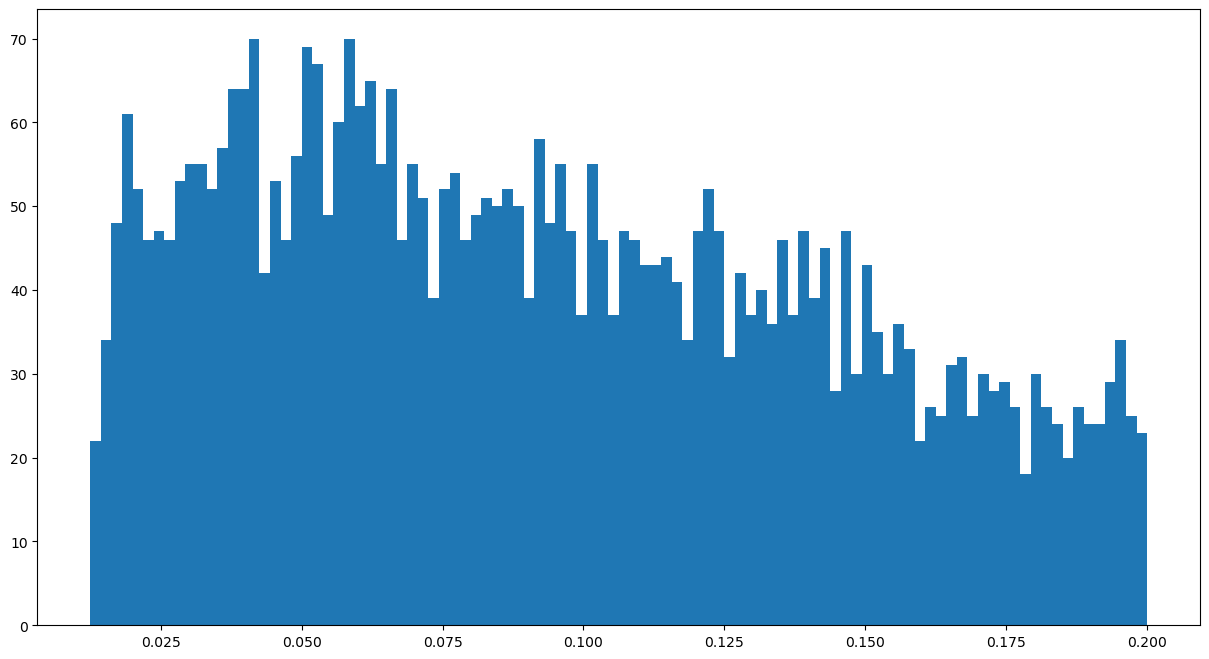

In [550]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['assists']);
plt.hist(df[(df['assists']<=0.2) & (df['assists']>0.0125)]['assists'],bins=100);

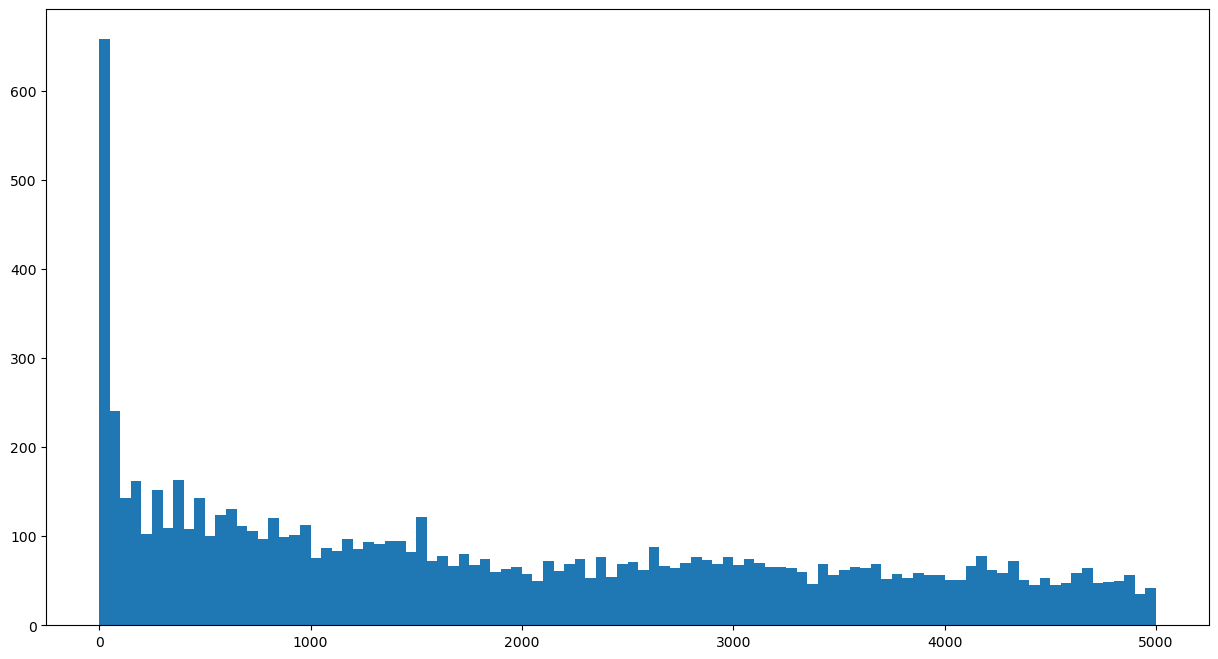

In [551]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['minutes played'])
plt.hist(df[df['minutes played']<=5000]['minutes played'],bins=100);

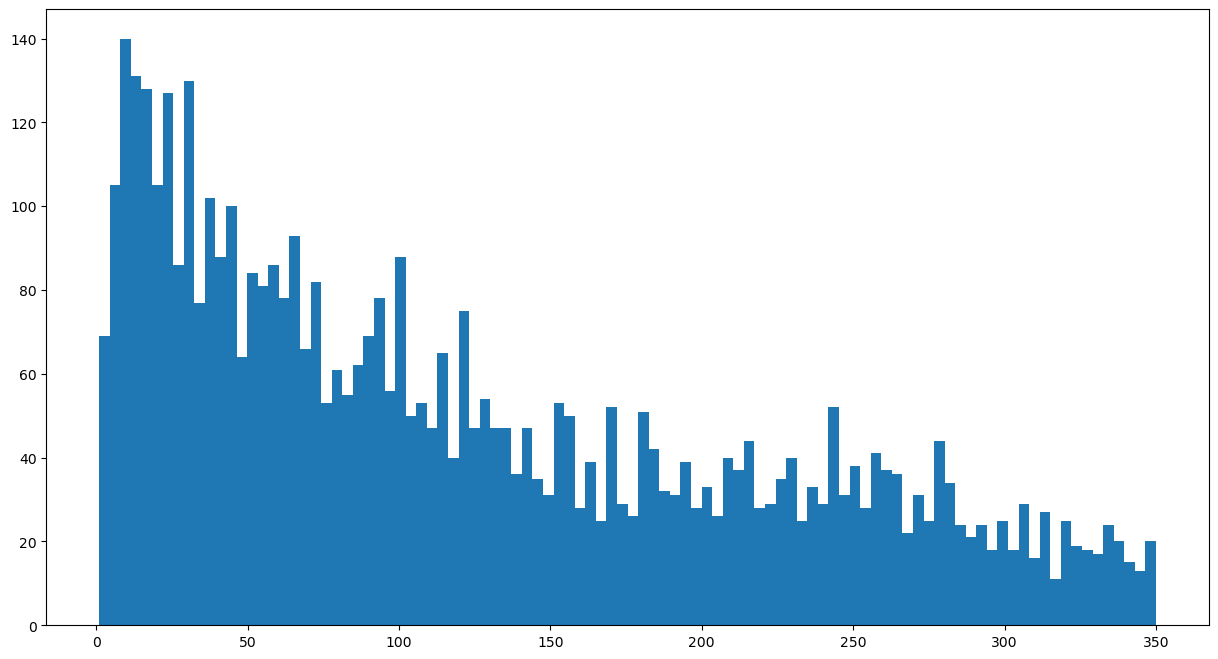

In [552]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['days_injured'])
plt.hist(df[(df['days_injured']<=350) & (df['days_injured']>0)]['days_injured'],bins=100);

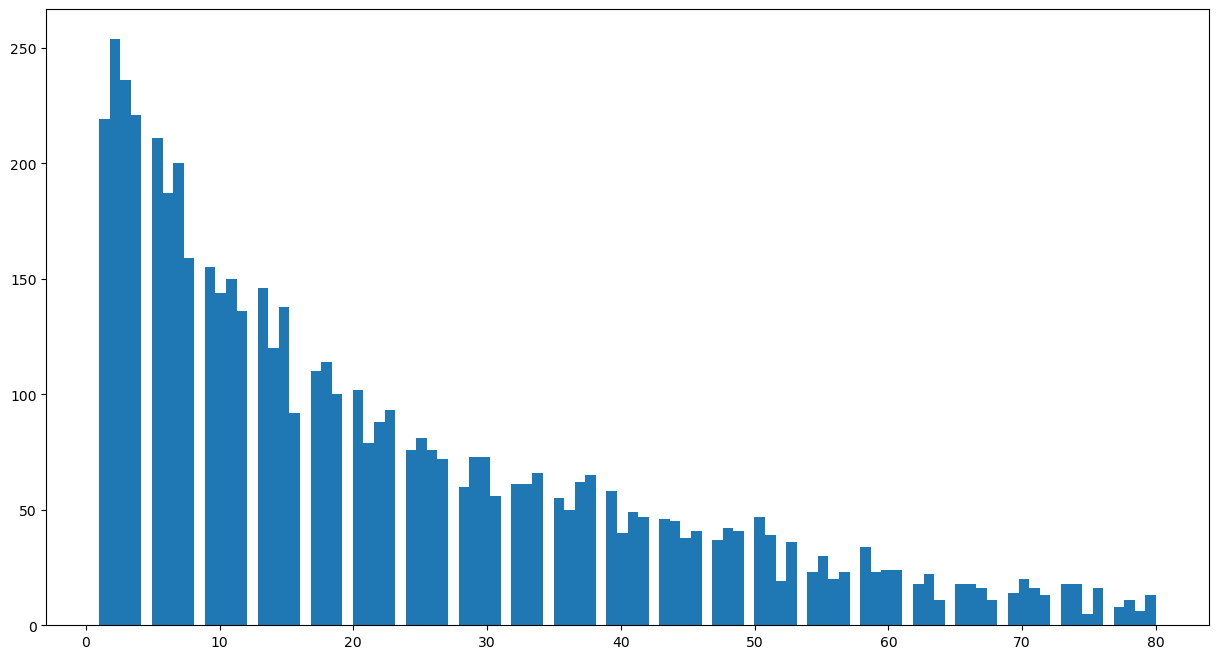

In [553]:
plt.figure(figsize=(15,8))
#plt.boxplot(player['games_injured'])
plt.hist(df[(df['games_injured']<=80) & (df['games_injured']>0)]['games_injured'],bins=100);

In [554]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_leval_category_encoded']) > \
threshold]['player_leval_category_encoded'].index
selected_features

Index(['appearance', 'goals', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'player_leval_category_encoded'],
      dtype='object')

In [555]:
selected_features = ['appearance', 'minutes played', 'highest_value',
       'player_leval_category_encoded']

In [556]:
df = df[selected_features]
df.head()

,appearance,minutes played,highest_value,player_leval_category_encoded
0,15,1304,22000000,1
1,4,292,6000000,1
2,68,4762,70000000,2
3,70,5471,35000000,2
4,34,2758,2000000,1


### 4. Prepare train and test data

In [557]:
# Prepare data
X = df.drop(['player_leval_category_encoded'], axis=1)

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [558]:
X.shape

(9529, 3)

## Buliding the Model


In [559]:
wcss = []
for i in range(1, 20):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    

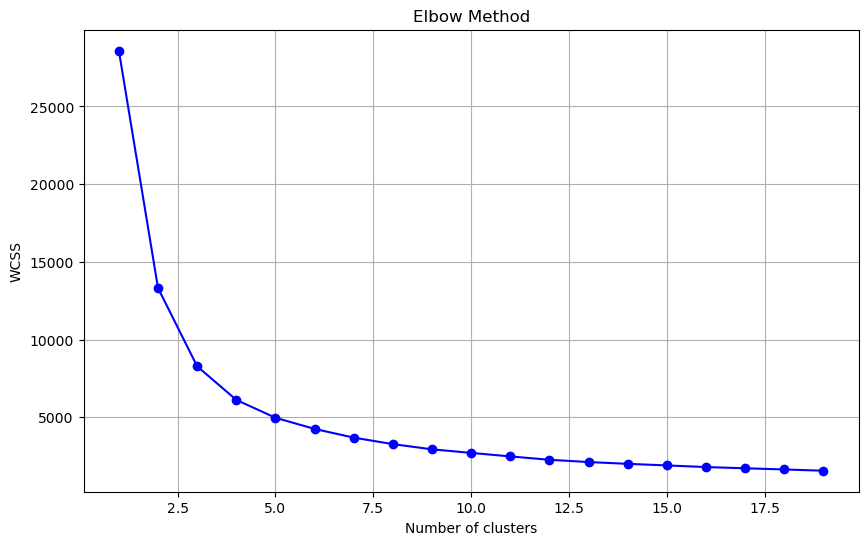

In [560]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [561]:
# Optional: Apply k-Means using the optimal number of clusters
optimal_clusters = 4 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

## Train and Test the Model


In [562]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

## Evaluating the Model


In [563]:
X.head(2)


,appearance,minutes played,highest_value
0,15,1304,22000000
1,4,292,6000000


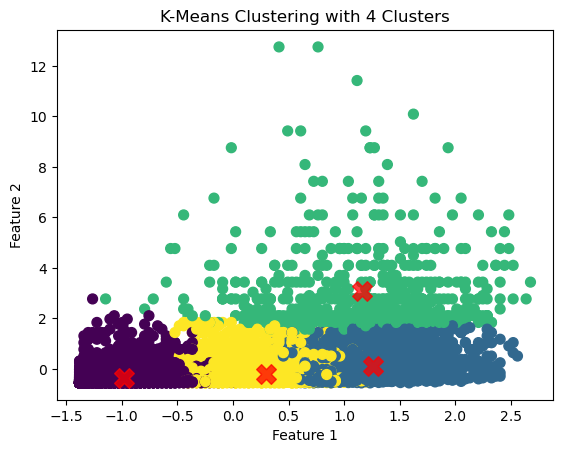

In [564]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 0], X_scaled[:, 2], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [565]:
X['kmeans'] = y_pred


In [566]:
X['kmeans'].value_counts()


kmeans
0    4150
3    2768
1    2013
2     598
Name: count, dtype: int64

In [567]:
X[X['kmeans']==2]



,appearance,minutes played,highest_value,kmeans
0,15,1304,22000000,2
2,68,4762,70000000,2
3,70,5471,35000000,2
5,89,7132,22000000,2
7,60,4783,40000000,2
...,...,...,...,...
8269,53,3020,20000000,2
8271,71,5481,30000000,2
8290,60,4752,22000000,2
8294,29,1596,20000000,2


<Axes: xlabel='minutes played', ylabel='highest_value'>

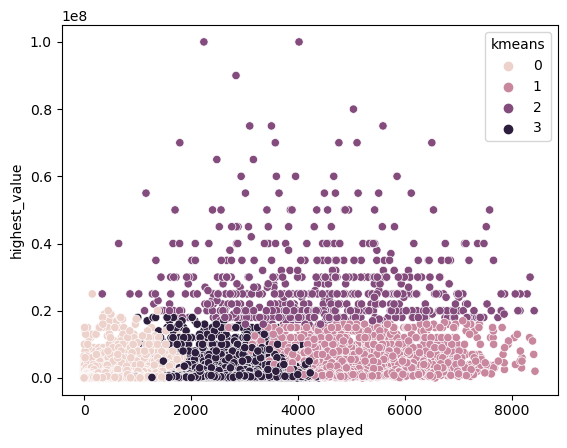

In [568]:
sns.scatterplot(data = X , x = 'minutes played', y = 'highest_value', hue = 'kmeans')


<Axes: xlabel='minutes played', ylabel='appearance'>

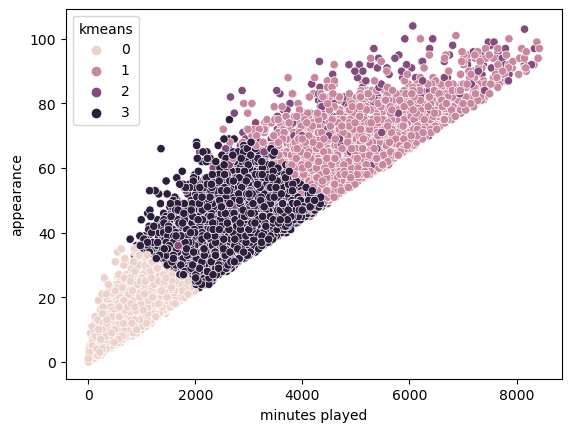

In [569]:
sns.scatterplot(data = X , x = 'minutes played', y = 'appearance', hue = 'kmeans')
